In [29]:
from PIL import Image
style.use('default')
from qiskit import QuantumCircuit
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
from qiskit_ibm_runtime import QiskitRuntimeService,  Session, Options
from qiskit import transpile
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from qiskit_ibm_runtime import SamplerV2 as Sampler
style.use('bmh')
from qiskit_aer import Aer
from qiskit.primitives import SamplerResult

In [3]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="8517bec216407d31487d5cb2ce893b43f356a831180bb0807a94effc8f4244187a435a2204a1a78574ac63fb7bea585e87db1165468f943218e9ddbcab3143b3", overwrite=True)

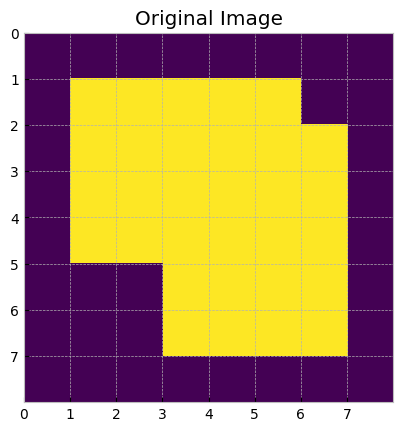

In [4]:
# A 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

plot_image(image, 'Original Image')

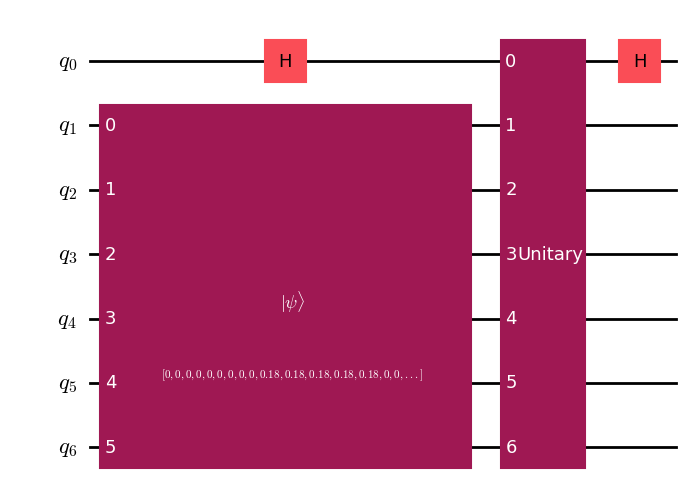

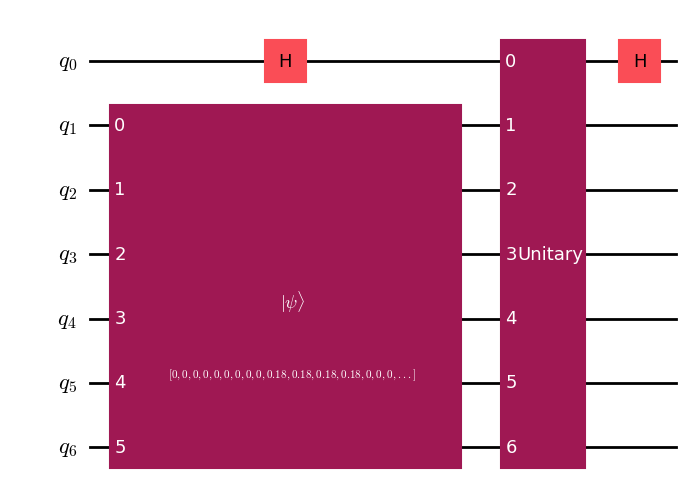

In [5]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [6]:
# Simulating the cirucits
sv_h = Statevector.from_instruction(qc_h)
sv_v = Statevector.from_instruction(qc_v)


print('Horizontal scan statevector:')
display(array_to_latex(sv_h.data[:30], max_size=30))
print()

print('Vertical scan statevector:')
display(array_to_latex(sv_v.data[:30], max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

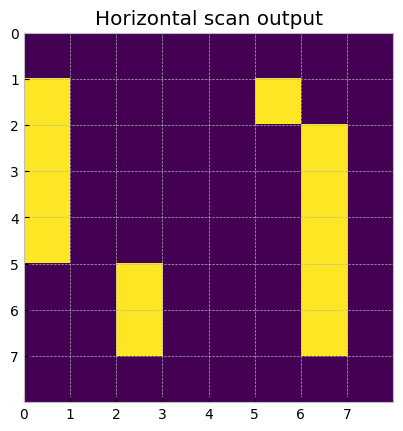

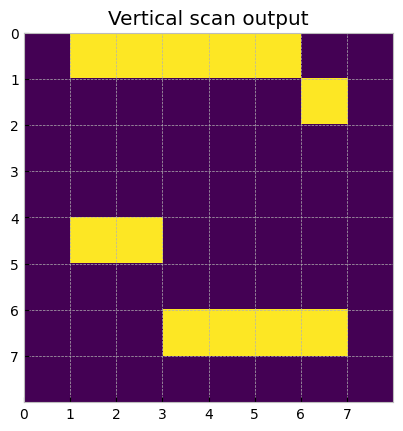

In [7]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

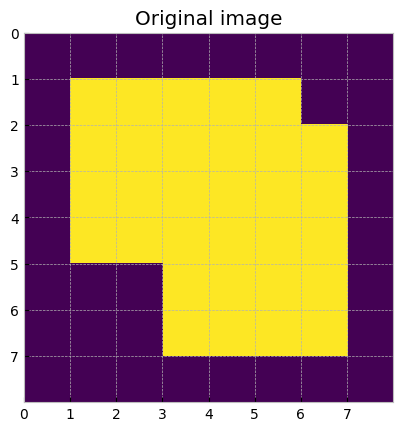

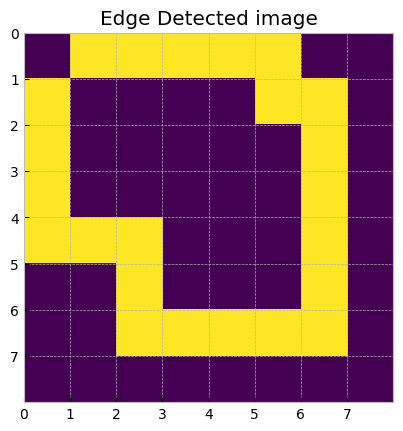

In [8]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

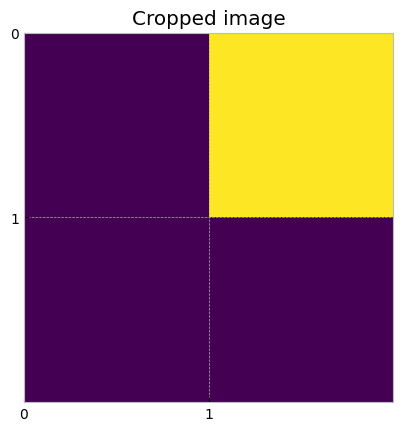

In [9]:
# Create a 2x2 image to be run on the hardware
# The pixels in `image_small` correspond to the pixels at
# (6, 2), (6, 3), (7, 2), (7, 3) respectively
image_small = image[6:8, 2:4]

# Plotting the image_small using matplotlib
plot_image(image_small, 'Cropped image')


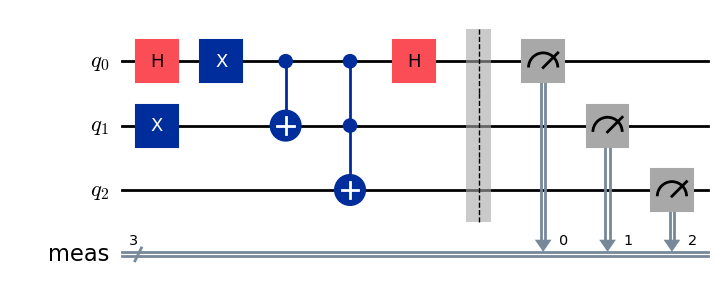

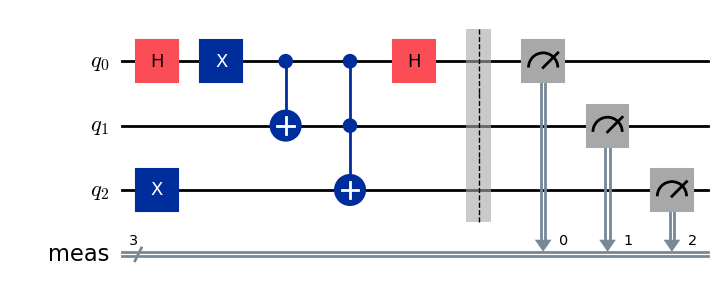

In [10]:
# Initialize the number of qubits
data_qb = 2
anc_qb = 1
total_qb = data_qb + anc_qb

# Create the circuit for horizontal scan
qc_small_h = QuantumCircuit(total_qb)
qc_small_h.x(1)
qc_small_h.h(0)

# Decrement gate - START
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# Decrement gate - END

qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

# Create the circuit for vertical scan
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)

# Decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# Decrement gate - END

qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# Combine both circuits into a single list
circ_list = [qc_small_h, qc_small_v]

/tmp/ipykernel_12552/959356511.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


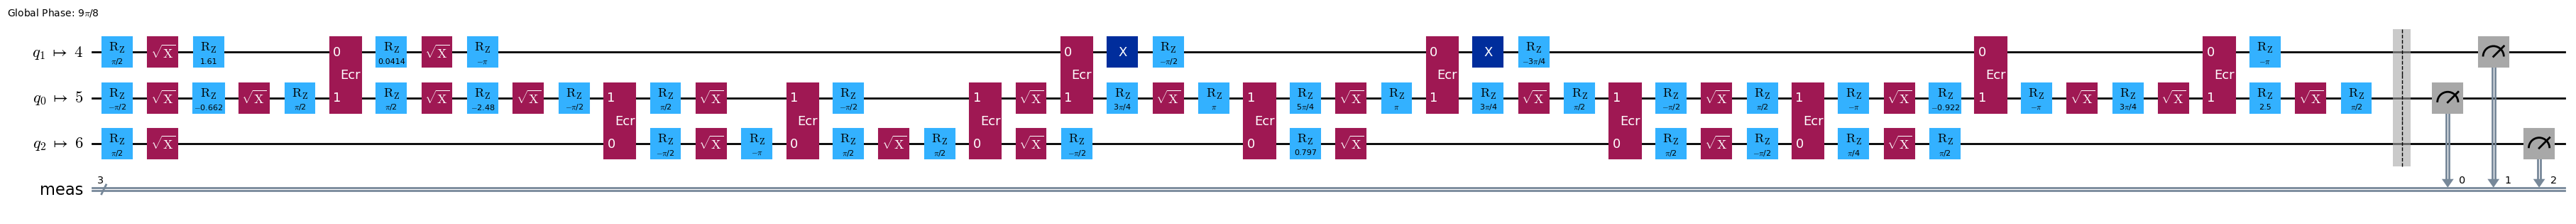

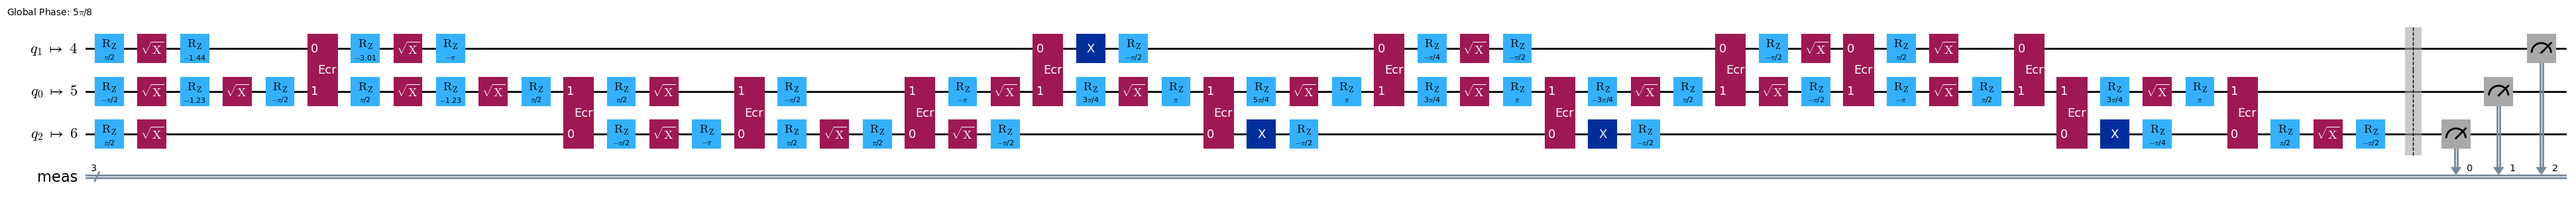

In [18]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
# Transpile the circuits for optimized execution on the backend
qc_small_h_t = transpile(qc_small_h,backend=backend ,optimization_level=3)
qc_small_v_t = transpile(qc_small_v,backend=backend, optimization_level=3)

# Store in a list if needed
circ_list_t = [qc_small_h_t, qc_small_v_t]

# Draw transpiled circuits using modern API
display(circuit_drawer(circ_list_t[0], output="mpl", fold=-1))
display(circuit_drawer(circ_list_t[1], output="mpl", fold=-1))

In [19]:
with Session(backend=backend) as session:
    sampler = Sampler()
    job = sampler.run(circ_list_t)
    result = job.result()

Counts for Horizontal scan:


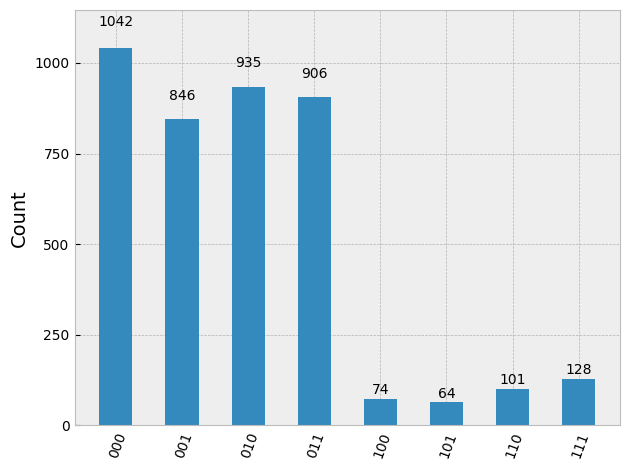



Counts for Vertical scan:


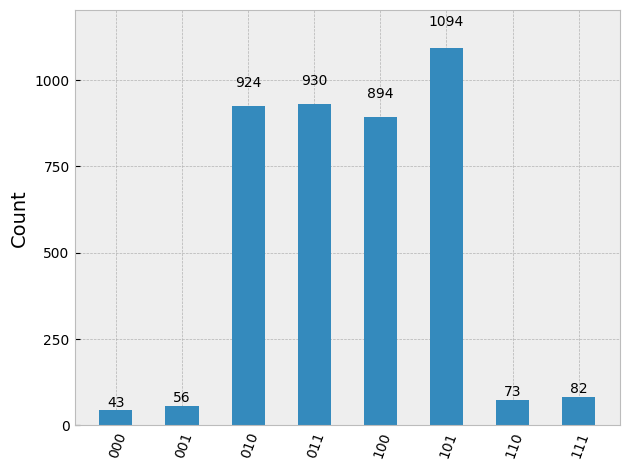

In [23]:
counts_h = result[0].data.meas.get_counts()
counts_v = result[1].data.meas.get_counts()

print('Counts for Horizontal scan:')
display(plot_histogram(counts_h))

print('\n\nCounts for Vertical scan:')
display(plot_histogram(counts_v))

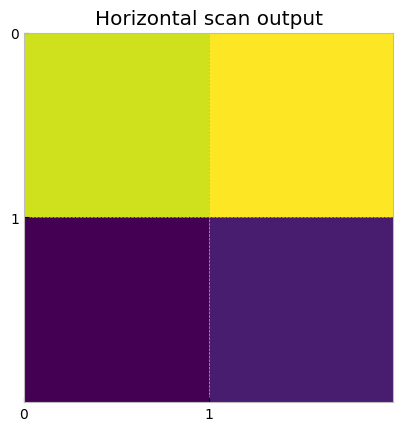

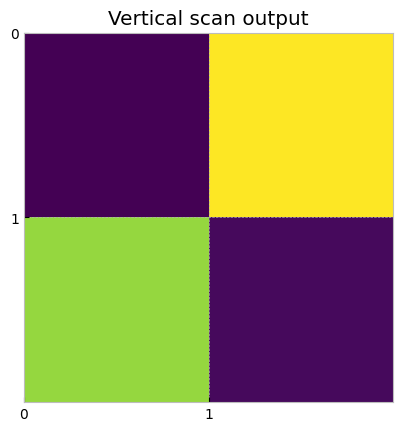

In [24]:
# Extracting counts for odd-numbered states
edge_scan_small_h = np.array([counts_h[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2, 2)
edge_scan_small_v = np.array([counts_v[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2, 2).T

plot_image(edge_scan_small_h, 'Horizontal scan output')
plot_image(edge_scan_small_v, 'Vertical scan output')

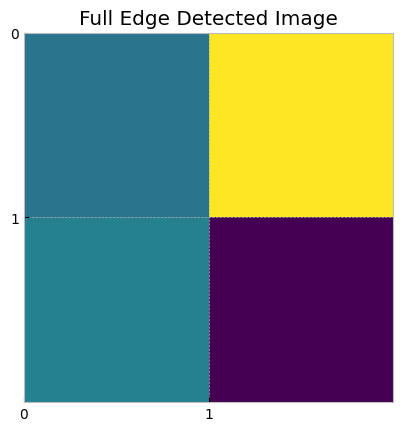

In [25]:
edge_detected_image_small = edge_scan_small_h + edge_scan_small_v

# Plotting the original and edge-detected images
plot_image(edge_detected_image_small, 'Full Edge Detected Image')

Para correr em Simulação


In [26]:
Sv_h2 = Statevector.from_instruction(circ_list_t[0])
Sv_v2 = Statevector.from_instruction(circ_list_t[1],)


edge_scan_h2 = np.abs(np.array([1 if threshold(Sv_h2[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v2 = np.abs(np.array([1 if threshold(Sv_v2[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h2, 'Horizontal scan output')
plot_image(edge_scan_v2, 'Vertical scan output')

ValueError: Maximum allowed dimension exceeded

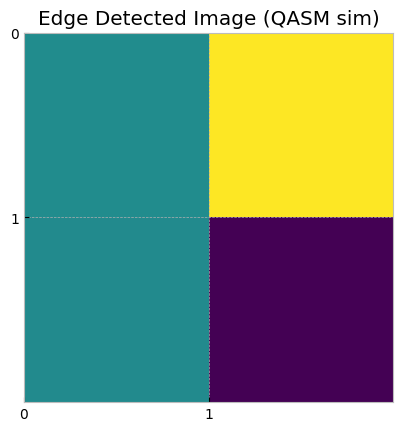

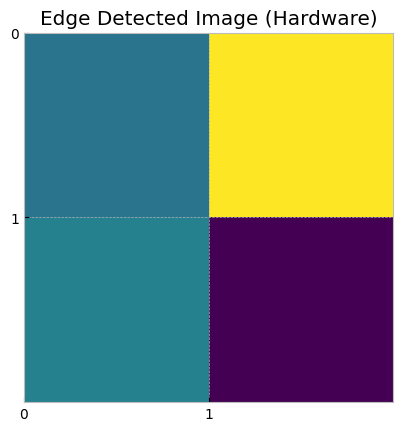

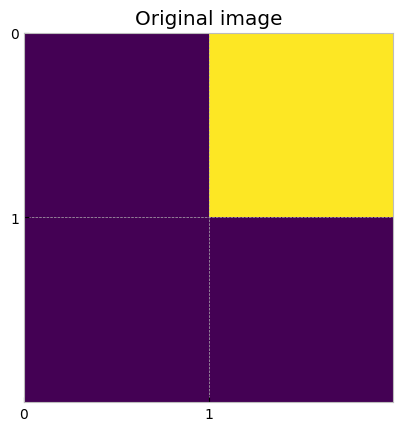

In [28]:
# Initialise the qasm_simulator from the Aer package
sim = Aer.get_backend('qasm_simulator')
res = sim.run(circ_list_t, shots=8192).result()
sim_counts_h = res.get_counts(qc_small_h)
sim_counts_v = res.get_counts(qc_small_v)

# Get the measurement counts from the result
sim_keys_h = sim_counts_h.keys()
sim_keys_v = sim_counts_v.keys()

# Filter and extract the counts for odd-numbered states
# and make the full edge-detected image by adding horizontal and vertical scans
edge_scan_sim_h = np.array([sim_counts_h[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_h else 0 for i in range(2**data_qb)]).reshape(2, 2)
edge_scan_sim_v = np.array([sim_counts_v[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_v else 0 for i in range(2**data_qb)]).reshape(2, 2).T
edge_detected_sim_small = edge_scan_sim_h + edge_scan_sim_v

# Plot all the simulator-run, hardware-run, and original images
plot_image(edge_detected_sim_small, 'Edge Detected Image (QASM sim)')
plot_image(edge_detected_image_small, 'Edge Detected Image (Hardware)')
plot_image(image_small, 'Original image')

In [ ]:
image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('./images/edge_detection_input.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()